# setting

In [1]:
import sys
import os
home = os.path.expanduser("~")
sys.path.append(f'{home}/TorchFiber')

import pickle, torch, numpy as np, time
from torch.optim import Adam
from src.TorchDSP.core import TorchInput, TorchSignal, TorchTime
from src.TorchDSP.dsp import DSP
from src.TorchDSP.dataloader import signal_dataset

batch_size = 120
device = 'cuda:0'

# dataset


# define model
DBP_info = {'step':5, 'dtaps': 5421,  'ntaps':401, 'type': 'MetaDBP', 'Nmodes':1,
            'L':2000e3, 'D':16.5, 'Fc':299792458/1550E-9, 'gamma':0.0016567, 
           'linear_kernel_type':'physical', 'linear_share':True, 'nonlinear_share':True,'optic_params_trainable': False,}
ADF_type = 'metalstm'       # 'metalstm', 'metalr', 'ddlms'

# Testing

In [5]:
import torch, matplotlib.pyplot as plt, time
from src.TorchDSP.dsp import DSP
from src.TorchDSP.dataloader import signal_dataset, train_data, test_data

test_dataset = signal_dataset(test_data, batch_size=360, shuffle=False)
dic_fdbp = torch.load('models/torch/FDBP_DDLMS_datafew_9.pth')
dic_metadsp = torch.load('models/torch/MetaDBP_MetaLSTM_datafew_6.pth')


def test_model(dic, dataset, device='cuda:0'):
    model = DSP(**dic['model info'])
    model.load_state_dict(dic['model'])
    model.change_mode('test', batch_size=dataset.batch_size)
    model.eval()

    res = []

    for data in dataset:
        t0 = time.time()

        with torch.no_grad():
            model.adf.init_state()
            model = model.to(device)
            data = data.to(device)
            predict = model(data.signal_input, data.task_info, data.signal_output)
            truth = data.signal_output.val[:, predict.t.start:predict.t.stop]
            model.adf.detach_state()
        
        t1 = time.time()

        print('time: ', t1-t0)

        res.append((predict.val.to('cpu'), truth.to('cpu'), data.task_info.to('cpu')))
    
    
    return  torch.cat([k[0] for k in res], dim=0), torch.cat([k[1] for k in res], dim=0), torch.cat([k[2] for k in res], dim=0) # type: ignore


FDBP = DSP(**dic_fdbp['model info'])
FDBP.load_state_dict(dic_fdbp['model'])
FDBP.eval()

MetaDSP = DSP(**dic_metadsp['model info'])
MetaDSP.load_state_dict(dic_metadsp['model'])
MetaDSP.eval()

print('model load done')

ImportError: cannot import name 'train_data' from 'src.TorchDSP.dataloader' (/home/xiaoxinyu/TorchFiber/src/TorchDSP/dataloader.py)

In [21]:
predict1, truth1, task_info1 = test_model(dic_fdbp, test_dataset, device='cuda:0')

time:  107.819082736969


In [24]:
predict2, truth2, task_info2 = test_model(dic_metadsp, test_dataset, device='cuda:0')

time:  317.62693786621094


In [34]:
from TorchSimulation.receiver import  BER 

device = 'cpu'

n = 20000
res1 = BER(predict1[:,n:].to(device), truth1[:,n:].to(device))
res2 = BER(predict2[:,n:].to(device), truth2[:,n:].to(device))

/home/xiaoxinyu/TorchFiber/TorchSimulation/receiver.py:167: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.sqrt(2) * np.maximum(special.erfcinv(2 * ber), 0.))


In [41]:
pickle.dump([res1, res2], open('data/metric_few.pkl', 'wb'))

(4.0, 13.0)

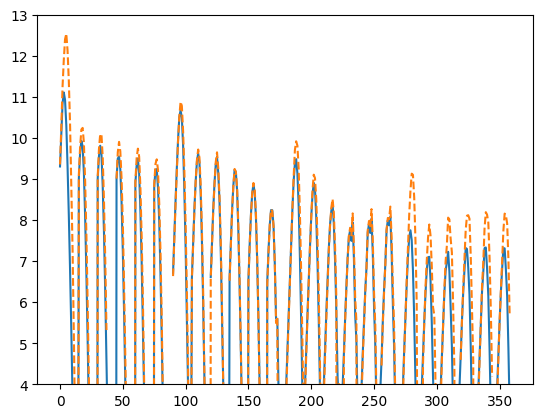

In [38]:
plt.plot(res1['Qsq'])
plt.plot(res2['Qsq'], '--')
plt.ylim(4, 13)

## train loss

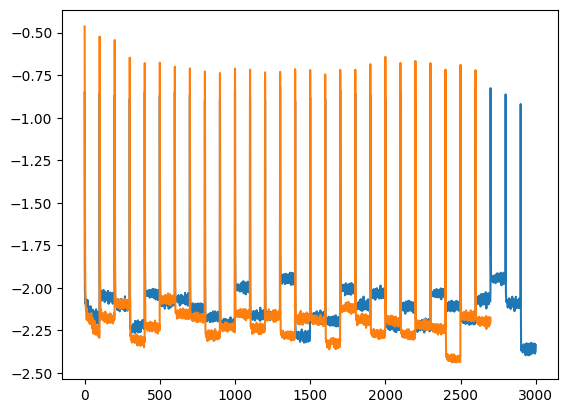

In [22]:
dic_fdbp = torch.load('models/torch/FDBP_DDLMS_datafew_9.pth')
dic_metadsp = torch.load('models/torch/MetaDBP_MetaLSTM_datafew_8.pth')

plt.plot(dic_fdbp['loss'])
plt.plot(dic_metadsp['loss'])

## nonlinear kernel

In [4]:
for data in test_dataset:
    break

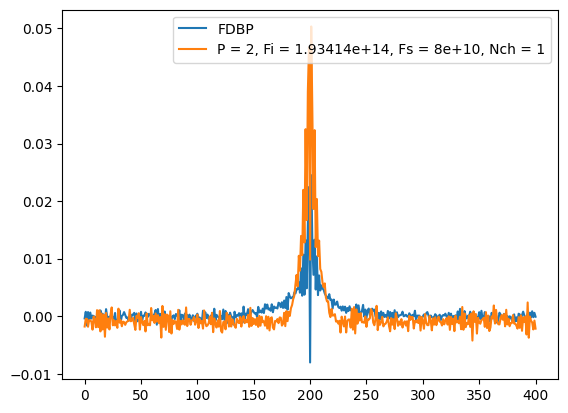

In [24]:
import matplotlib.pyplot as plt
plt.plot(FDBP.ldbp.task_mlp(data.task_info[0]).to('cpu').data, label='FDBP')
plt.plot(MetaDSP.ldbp.task_mlp(data.task_info[10]).to('cpu').data, label=('P = %g, Fi = %g, Fs = %g, Nch = %g' % tuple(data.task_info[100])))
plt.legend()

## show Fig

P,Fi,Fs,Nch tensor([2.0000e+00, 1.9341e+14, 1.6000e+11, 3.0000e+00], device='cuda:0')


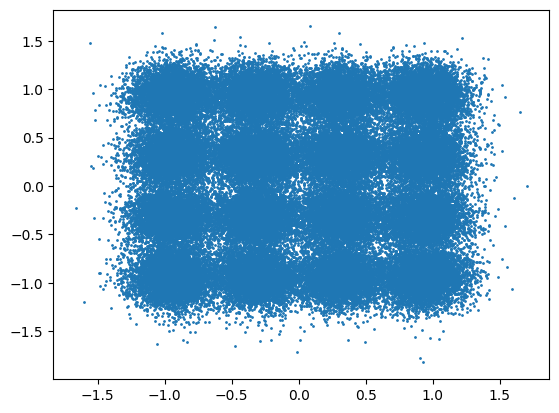

In [53]:
import matplotlib.pyplot as plt
from JaxSimulation.utils import show_symb

k = 7
print('P,Fi,Fs,Nch',data.task_info[k])
plt.scatter(y.val[k].data.to('cpu').real, y.val[k].data.to('cpu').imag, s=1)


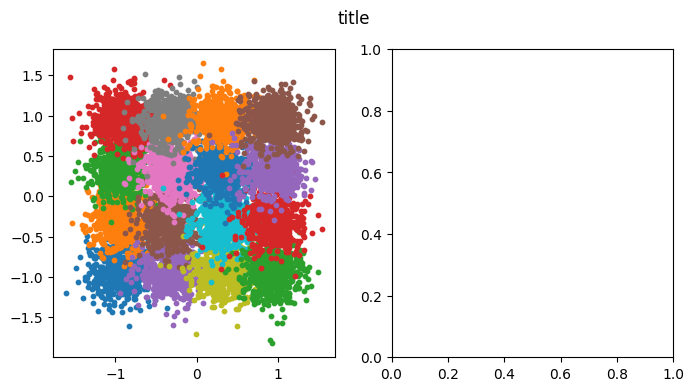

In [54]:
show_symb(y.val[k, 2000:12000].to('cpu').numpy(), truth[k, 2000:12000].to('cpu').numpy())

In [ ]:
y,x,t = pickle.load(open('res.pkl','rb'))
from TorchSimulation.receiver import BER
res = BER(torch.tensor(y), torch.tensor(x))

# Training

In [2]:
# training details
epochs = 1
iters_per_batch = 10
tbpl = 1000                    # trucated backpropagation length
L = tbpl + net.overlaps
net = net.to(device)
optimizer = Adam(net.parameters(), lr=1e-4)
loss_list = []


for epoch in range(epochs):
    dataset = signal_dataset(train_data, batch_size=batch_size, shuffle=True)
    for data in dataset:
        net.adf.init_state()
        net = net.to(device)
        for i in range(iters_per_batch):
            t0 = time.time()
            x = data.get_data(L, i).to(device)
            y = net(x.signal_input, x.task_info, x.signal_output)
            truth = x.signal_output.val[:, y.t.start:y.t.stop]
            loss = torch.log(torch.mean(torch.abs(y.val - truth)**2))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            net.adf.detach_state()

            t1 = time.time()

            if i % 1 == 0:
                print(f'iter {i}:  {loss.item()}     time cost per iteration: {t1 - t0}',)
            loss_list.append(loss.item())

torch.save(net.state_dict(), 'models/torch/net.pth')

iter 0:  -0.43079450726509094     time cost per iteration: 12.508715867996216
iter 1:  -0.9508932828903198     time cost per iteration: 10.39260721206665
iter 2:  -1.3407307863235474     time cost per iteration: 10.458815813064575
iter 3:  -1.5611374378204346     time cost per iteration: 10.523346424102783
iter 4:  -1.7280166149139404     time cost per iteration: 10.738197565078735
iter 5:  -1.8200596570968628     time cost per iteration: 10.224819421768188
iter 6:  -1.8563469648361206     time cost per iteration: 10.905267715454102
iter 7:  -1.8725225925445557     time cost per iteration: 10.316933393478394
iter 8:  -1.9223058223724365     time cost per iteration: 11.154179096221924
iter 9:  -1.921165943145752     time cost per iteration: 10.971496105194092
iter 0:  -0.4334445893764496     time cost per iteration: 10.012173414230347
iter 1:  -1.0865215063095093     time cost per iteration: 10.31671953201294
iter 2:  -1.4894282817840576     time cost per iteration: 10.274971723556519
i

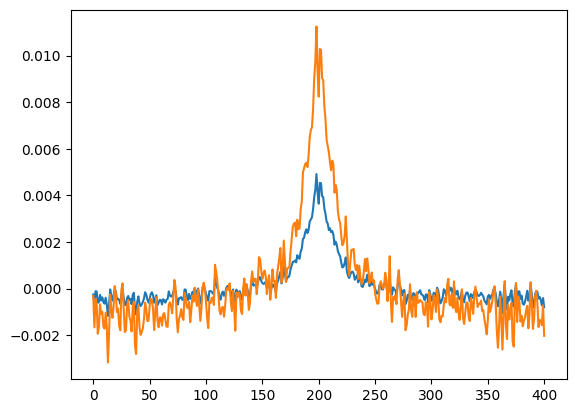

In [7]:
import matplotlib.pyplot as plt
plt.plot(net.ldbp.task_mlp(x.task_info[0]).to('cpu').data)
plt.plot(net.ldbp.task_mlp(x.task_info[21]).to('cpu').data)

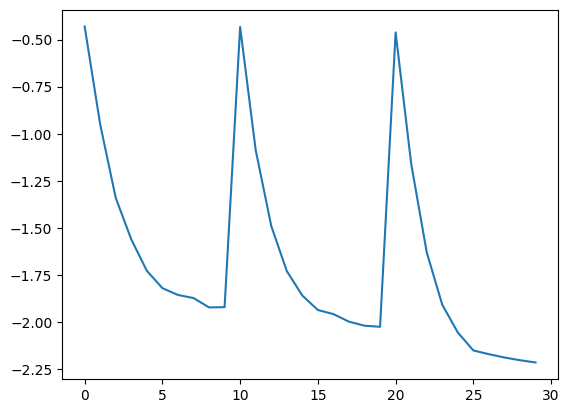

In [25]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

# baselines

In [2]:
import torch, matplotlib.pyplot as plt, time
from TorchDSP.baselines import CDCDSP, DBPDSP
from TorchDSP.dataloader import signal_dataset, train_data, test_data
from TorchSimulation.receiver import  BER 

test_dataset = signal_dataset(test_data, batch_size=360, shuffle=False)

/home/xiaoxinyu/.conda/envs/fiber/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
predict, truth, task_info = CDCDSP(test_dataset, device='cuda:0')

 CDCDSP complete, time cost(s):102.48182702064514


In [2]:
predict1, truth1, task_info1 = DBPDSP(test_dataset, stps=5, device='cuda:0')

 DBPDSP complete, time cost(s):136.7630684375763


In [3]:
res = BER(predict[:,20000:].to('cpu'), truth[:,20000:].to('cpu'))

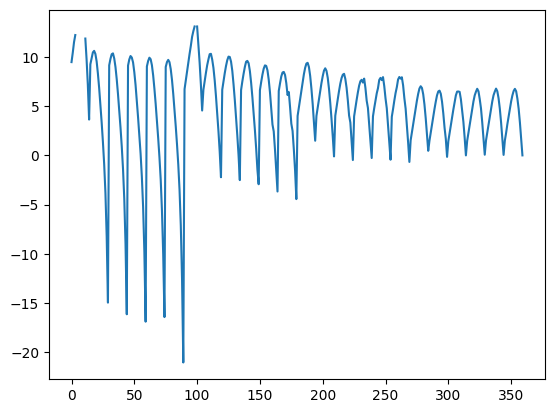

In [9]:
plt.plot(res2['Qsq'])

In [12]:
6*15

90

In [10]:
# Rs, Nch, P
nch = np.unique(test_dataset.data.a['channels']).__len__()
rs = np.unique(test_dataset.data.a['samplerate']).__len__()
p = np.unique(test_dataset.data.a['lpdbm']).__len__()

test_dataset.data.a['channels'].reshape(rs, nch, p)[:,0]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [16]:
import numpy as np

np.unique(torch.arange(4))

array([0, 1, 2, 3])